<a href="https://colab.research.google.com/github/HaqTetsuya/rusdi-prototype-1/blob/main/rusdi_prototype_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title download dependancy
# Cell 1: Instalasi library yang diperlukan
!pip install transformers torch pandas scikit-learn matplotlib seaborn tqdm deep-translator


In [37]:
# @title import dependency, load drive, and github {"form-width":"20%"}
!git clone https://github.com/HaqTetsuya/rusdi-prototype-1.git

import json
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from google.colab import drive, files
from plotly.subplots import make_subplots
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
#from tqdm import tqdm
from tqdm.auto import tqdm  # If you need both tqdm and tqdm.auto
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_scheduler

drive.mount('/content/drive')
FName = "indobert_intent_model2" #@param {type:"string"}

# Update MODEL_SAVE_PATH with user input
MODEL_SAVE_PATH = f"/content/drive/MyDrive/{FName}"


# Cell 4: Kelas Dataset untuk IndoBERT
class IntentDataset(Dataset):
    """Dataset untuk klasifikasi intent dengan IndoBERT"""

    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        # Convert dict of tensors to flat tensors
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.tensor(label)

        return item

fatal: destination path 'rusdi-prototype-1' already exists and is not an empty directory.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
# @title load data

def load_csv_data(csv_path, label_encoder=None, show_distribution=False):
    """Memuat data intent dari file CSV. Bisa untuk train/test tanpa split."""
    print(f"\nMemuat data dari: {csv_path}")

    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"File tidak ditemukan: {csv_path}")

    df = pd.read_csv(csv_path)

    if 'text' not in df.columns or 'intent' not in df.columns:
        raise ValueError("Kolom 'text' dan 'intent' harus ada di CSV")

    if label_encoder is None:
        label_encoder = LabelEncoder()
        df['intent_encoded'] = label_encoder.fit_transform(df['intent'])
        intent_classes = label_encoder.classes_
        print(f"Label encoder baru dibuat dari data {csv_path}")
    else:
        df['intent_encoded'] = label_encoder.transform(df['intent'])
        intent_classes = label_encoder.classes_
        print(f"Menggunakan label encoder yang sudah ada")

    if show_distribution:
        intent_counts = df['intent'].value_counts()
        print("\nDistribusi intent:")
        for intent, count in intent_counts.items():
            print(f"  {intent}: {count}")

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        sns.barplot(x=intent_counts.index, y=intent_counts.values, palette="viridis")
        plt.xlabel("Intent")
        plt.ylabel("Jumlah Sampel")
        plt.title("Distribusi Intent")
        plt.xticks(rotation=45)

        plt.subplot(1, 2, 2)
        plt.pie(intent_counts, labels=intent_counts.index, autopct='%1.1f%%', colors=sns.color_palette("viridis", len(intent_counts)))
        plt.title("Proporsi Intent")
        plt.tight_layout()
        plt.show()

    texts = df['text'].values
    labels = df['intent_encoded'].values

    return texts, labels, intent_classes, label_encoder


In [39]:
# @title  setup model IndoBERT
def setup_indobert_for_intent(num_labels):
    """Load model IndoBERT untuk klasifikasi intent"""

    print("Memuat model IndoBERT...")
    tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
    model = AutoModelForSequenceClassification.from_pretrained(
        "indobenchmark/indobert-base-p1",
        num_labels=num_labels
    )
    print("Model berhasil dimuat")

    return model, tokenizer

In [40]:
# @title kalibrasi OOD
def calibrate_ood_detection(model, tokenizer, dataloader, temperature=1.0, percentile=85):
    """
    Kalibrasi threshold untuk OOD detection menggunakan data in-distribution
    dengan metode Energy-based dan MSP (Maximum Softmax Probability)
    """
    device = next(model.parameters()).device
    model.eval()

    # Untuk Energy method dan MSP method
    energy_scores = []
    msp_scores = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Kalibrasi OOD detection"):
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            outputs = model(**inputs)
            logits = outputs.logits

            # Energy score (nilai lebih tinggi untuk OOD)
            energy = -temperature * torch.logsumexp(logits / temperature, dim=1)
            energy_scores.extend(energy.cpu().numpy())

            # MSP score (nilai lebih rendah untuk OOD)
            softmax_probs = F.softmax(logits, dim=1)
            max_probs, _ = torch.max(softmax_probs, dim=1)
            msp_scores.extend(max_probs.cpu().numpy())

    # Hitung threshold untuk Energy (maksimal energy untuk in-distribution)
    energy_threshold = np.percentile(energy_scores, percentile)

    # Hitung threshold untuk MSP (minimal probability untuk in-distribution)
    msp_threshold = np.percentile(msp_scores, 100 - percentile)  # Inverse percentile karena higher = better

    return {
        "energy_threshold": float(energy_threshold),
        "msp_threshold": float(msp_threshold)
    }
def save_ood_thresholds(thresholds, save_path):
    """
    Menyimpan threshold OOD ke file JSON
    """
    threshold_file = os.path.join(save_path, "ood_thresholds.json")
    with open(threshold_file, 'w') as f:
        json.dump(thresholds, f, indent=4)
    print(f"OOD thresholds disimpan di {threshold_file}")
    return threshold_file

def load_ood_thresholds(model_path):
    """
    Memuat threshold OOD dari file JSON
    """
    # Coba load thresholds.json terlebih dahulu (format baru)
    try:
        with open(os.path.join(model_path, "ood_thresholds.json"), 'r') as f:
            thresholds = json.load(f)
            return thresholds
    except FileNotFoundError:
        # Jika tidak ditemukan, coba load format lama
        try:
            with open(os.path.join(model_path, "ood_threshold.json"), 'r') as f:
                threshold_data = json.load(f)
                return {
                    "energy_threshold": threshold_data["energy_threshold"],
                    "msp_threshold": None  # Tidak ada dalam format lama
                }
        except FileNotFoundError:
            print("Warning: OOD threshold files not found. Using default thresholds.")
            return {
                "energy_threshold": 0.0,  # Default fallback value
                "msp_threshold": 0.5  # Default fallback value
            }

In [41]:
#@title Training function

def train_intent_classifier(model, tokenizer, train_texts, train_labels, val_texts, val_labels,
                           batch_size=16, epochs=10, learning_rate=2e-5, weight_decay=0.01,
                           save_path=MODEL_SAVE_PATH, use_class_weights=True, patience=3, class_names=None):
    """
    Melatih model IndoBERT untuk klasifikasi intent dengan perbaikan:
    - Enhanced visualization (interactive and static)
    - Per-class metric tracking
    - Confusion matrix generation
    - Batch-level metric tracking
    - Learning rate visualization
    """

    # Persiapkan dataset
    print("Menyiapkan dataset...")
    train_dataset = IntentDataset(train_texts, train_labels, tokenizer)
    val_dataset = IntentDataset(val_texts, val_labels, tokenizer)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

    # Compute class weights if needed
    if use_class_weights:
        # Get unique classes
        unique_classes = np.unique(train_labels)
        # Compute weights
        weights = compute_class_weight(
            class_weight='balanced',
            classes=unique_classes,
            y=train_labels
        )
        # Convert to tensor
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        class_weights = torch.FloatTensor(weights).to(device)
        print(f"Menggunakan class weights: {weights}")
    else:
        class_weights = None

    # Optimizer dengan weight decay untuk regularisasi
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Scheduler dengan warmup
    num_training_steps = len(train_dataloader) * epochs
    num_warmup_steps = int(0.1 * num_training_steps)  # 10% warmup
    scheduler = get_scheduler("cosine", optimizer=optimizer,
                             num_warmup_steps=num_warmup_steps,
                             num_training_steps=num_training_steps)

    # Cek untuk GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Menggunakan device: {device}")
    model.to(device)
    print(f"Mulai pelatihan model...")
    print(f"Total epoch: {epochs}, batch size: {batch_size}, learning rate: {learning_rate}, weight decay: {weight_decay}")

    # Create loss function with class weights if needed
    if class_weights is not None:
        loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
    else:
        loss_fn = torch.nn.CrossEntropyLoss()

    # Enhanced logging training with batch-level tracking
    best_val_loss = float('inf')
    counter = 0  # Counter for early stopping
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': [],
        'val_f1': [],
        'val_precision': [],
        'val_recall': [],
        'batch_metrics': {
            'iteration': [],
            'loss': [],
            'epoch': [],
            'progress': [],
            'learning_rates': []
        },
        'class_f1': [],  # Per-class F1 scores
        'class_precision': [],  # Per-class precision
        'class_recall': []  # Per-class recall
    }

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        tqdm.write(f"\nEpoch {epoch+1}/{epochs} - Training dimulai...")
        progress_bar = tqdm(enumerate(train_dataloader), total=len(train_dataloader),
                         desc=f"Epoch {epoch+1}/{epochs} [Training]", leave=False)

        for batch_idx, batch in progress_bar:
            try:
                # Pindahkan batch ke device
                inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
                labels = batch['labels'].to(device)

                # Forward pass with custom loss function
                optimizer.zero_grad()

                # Modified to use our loss function instead of the model's default
                outputs = model(**inputs)
                logits = outputs.logits
                loss = loss_fn(logits, labels)

                # Backward pass
                loss.backward()

                # Gradient clipping to prevent exploding gradients
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                optimizer.step()
                scheduler.step()

                # Track batch-level metrics
                iterations_per_epoch = len(train_dataloader)
                global_iteration = epoch * iterations_per_epoch + batch_idx
                progress = (epoch + (batch_idx / iterations_per_epoch)) * 100

                history['batch_metrics']['iteration'].append(global_iteration)
                history['batch_metrics']['loss'].append(loss.item())
                history['batch_metrics']['epoch'].append(epoch)
                history['batch_metrics']['progress'].append(progress)
                history['batch_metrics']['learning_rates'].append(optimizer.param_groups[0]['lr'])

                train_loss += loss.item()
                progress_bar.set_postfix({'loss': f"{loss.item():.4f}"})

            except RuntimeError as e:
                if "out of memory" in str(e):
                    tqdm.write("Peringatan: Kehabisan memori! Membersihkan cache...")
                    torch.cuda.empty_cache()
                    continue
                else:
                    raise e

        avg_train_loss = train_loss / len(train_dataloader)
        history['train_loss'].append(avg_train_loss)

        # Validation phase
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []

        tqdm.write(f"Epoch {epoch+1}/{epochs} - Validasi dimulai...")
        progress_bar = tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{epochs} [Validation]", leave=False)

        with torch.no_grad():
            for batch in progress_bar:
                inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
                labels = batch['labels'].to(device)

                outputs = model(**inputs)
                logits = outputs.logits
                loss = loss_fn(logits, labels)
                val_loss += loss.item()

                # Hitung akurasi
                predictions = torch.argmax(logits, dim=1)
                correct += (predictions == labels).sum().item()
                total += labels.size(0)

                # Collect predictions and labels for metrics
                all_preds.extend(predictions.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                progress_bar.set_postfix({'loss': f"{loss.item():.4f}"})

        # Calculate overall metrics
        avg_val_loss = val_loss / len(val_dataloader)
        accuracy = correct / total
        f1 = f1_score(all_labels, all_preds, average='weighted')
        precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)

        # Calculate per-class metrics
        class_f1 = f1_score(all_labels, all_preds, average=None, zero_division=0)
        class_precision = precision_score(all_labels, all_preds, average=None, zero_division=0)
        class_recall = recall_score(all_labels, all_preds, average=None, zero_division=0)

        # Save metrics to history
        history['val_loss'].append(avg_val_loss)
        history['val_accuracy'].append(accuracy)
        history['val_f1'].append(f1)
        history['val_precision'].append(precision)
        history['val_recall'].append(recall)

        # Save per-class metrics
        history['class_f1'].append(class_f1.tolist())
        history['class_precision'].append(class_precision.tolist())
        history['class_recall'].append(class_recall.tolist())

        # Generate confusion matrix for this epoch
        if class_names is not None:
            plot_confusion_matrix(all_labels, all_preds, class_names, epoch, save_path)

        # Print detailed metrics
        tqdm.write(f"Epoch {epoch+1}/{epochs}:")
        tqdm.write(f"  Train Loss: {avg_train_loss:.4f}")
        tqdm.write(f"  Val Loss: {avg_val_loss:.4f}, Val Accuracy: {accuracy*100:.2f}%")
        tqdm.write(f"  Val F1: {f1:.4f}, Val Precision: {precision:.4f}, Val Recall: {recall:.4f}")

        # Early stopping and model saving logic
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            counter = 0  # Reset early stopping counter

            if not os.path.exists(save_path):
                os.makedirs(save_path)

            tqdm.write(f"Menyimpan model terbaik ke {save_path}")
            model.save_pretrained(save_path)
            tokenizer.save_pretrained(save_path)

            # Save classification report for best model
            report = classification_report(all_labels, all_preds, output_dict=True)
            with open(os.path.join(save_path, "classification_report.json"), 'w') as f:
                json.dump(report, f, indent=4)
        else:
            counter += 1
            tqdm.write(f"Validation loss tidak membaik. Early stopping counter: {counter}/{patience}")

            if counter >= patience:
                tqdm.write(f"Early stopping triggered setelah {epoch+1} epochs")
                break

    tqdm.write(f"Pelatihan selesai! Model terbaik disimpan di {save_path}")

    # Generate enhanced visualizations
    enhanced_plot_training_results(history, save_path, class_names=class_names)

    # Simpan history ke file JSON
    save_enhanced_history(history, save_path)

    return model, history

def enhanced_plot_training_results(history, save_path, class_names=None):
    """
    Enhanced function to plot training results with more detailed visualizations

    Args:
        history: Dictionary containing training history metrics
        save_path: Path to save visualization files
        class_names: Optional list of class names for confusion matrix
    """
    # Create the static plots (same as before for compatibility)
    static_plot_training_results(history, save_path)

    # Create interactive plotly visualizations
    interactive_plot_training_results(history, save_path)

    # If we have class metrics in our history, plot those too
    if 'class_f1' in history and class_names is not None:
        plot_class_metrics(history, save_path, class_names)

    # If we tracked learning rates, plot those
    if 'learning_rates' in history:
        plot_learning_rate(history, save_path)

def static_plot_training_results(history, save_path):
    """Plot and save training metrics using matplotlib (static)"""
    plt.figure(figsize=(15, 10))

    # Plot 1: Loss
    plt.subplot(2, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss', marker='o')
    plt.plot(history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Loss selama Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot 2: Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(history['val_accuracy'], label='Validation Accuracy', marker='o', color='green')
    plt.title('Akurasi selama Training')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot 3: F1 Score
    plt.subplot(2, 2, 3)
    plt.plot(history['val_f1'], label='Validation F1', marker='o', color='purple')
    plt.title('F1 Score selama Training')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True)

    # Plot 4: Precision & Recall
    plt.subplot(2, 2, 4)
    plt.plot(history['val_precision'], label='Validation Precision', marker='o', color='orange')
    plt.plot(history['val_recall'], label='Validation Recall', marker='o', color='brown')
    plt.title('Precision & Recall selama Training')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()

    # Save the plot
    plt.savefig(os.path.join(save_path, "training_metrics.png"))
    plt.close()

def interactive_plot_training_results(history, save_path):
    """Create interactive plotly visualizations of training metrics"""
    # Create epochs list for x-axis
    epochs = list(range(1, len(history['train_loss']) + 1))

    # Create a DataFrame for easier plotting
    df = pd.DataFrame({
        'Epoch': epochs,
        'Training Loss': history['train_loss'],
        'Validation Loss': history['val_loss'],
        'Validation Accuracy': history['val_accuracy'],
        'Validation F1': history['val_f1'],
        'Validation Precision': history['val_precision'],
        'Validation Recall': history['val_recall']
    })

    # Create subplot figure
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Loss', 'Accuracy', 'F1 Score', 'Precision & Recall'),
        vertical_spacing=0.15,
        horizontal_spacing=0.1
    )

    # Add traces for each metric
    # Loss plot
    fig.add_trace(
        go.Scatter(x=epochs, y=history['train_loss'], mode='lines+markers', name='Training Loss'),
        row=1, col=1
    )
    fig.add_trace(
        go.Scatter(x=epochs, y=history['val_loss'], mode='lines+markers', name='Validation Loss'),
        row=1, col=1
    )

    # Accuracy plot
    fig.add_trace(
        go.Scatter(x=epochs, y=history['val_accuracy'], mode='lines+markers', name='Validation Accuracy', line=dict(color='green')),
        row=1, col=2
    )

    # F1 Score plot
    fig.add_trace(
        go.Scatter(x=epochs, y=history['val_f1'], mode='lines+markers', name='Validation F1', line=dict(color='purple')),
        row=2, col=1
    )

    # Precision & Recall plot
    fig.add_trace(
        go.Scatter(x=epochs, y=history['val_precision'], mode='lines+markers', name='Validation Precision', line=dict(color='orange')),
        row=2, col=2
    )
    fig.add_trace(
        go.Scatter(x=epochs, y=history['val_recall'], mode='lines+markers', name='Validation Recall', line=dict(color='brown')),
        row=2, col=2
    )

    # Update layout
    fig.update_layout(
        height=800,
        width=1200,
        title_text="Training Metrics (Interactive)",
        hovermode="x unified"
    )

    # Save interactive plot as HTML
    fig.write_html(os.path.join(save_path, "interactive_training_metrics.html"))

    # Create a combined metrics plot for better trend comparison
    fig_combined = px.line(
        df,
        x='Epoch',
        y=['Training Loss', 'Validation Loss', 'Validation Accuracy', 'Validation F1', 'Validation Precision', 'Validation Recall'],
        title='All Training Metrics',
        labels={'value': 'Metric Value', 'variable': 'Metric'}
    )

    fig_combined.update_layout(height=600, width=1000, hovermode="x unified")
    fig_combined.write_html(os.path.join(save_path, "combined_metrics.html"))

def plot_confusion_matrix(all_labels, all_preds, class_names, epoch, save_path):
    """Plot and save confusion matrix for the epoch"""
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.title(f'Confusion Matrix - Epoch {epoch+1}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()

    # Save the confusion matrix
    cm_dir = os.path.join(save_path, "confusion_matrices")
    os.makedirs(cm_dir, exist_ok=True)
    plt.savefig(os.path.join(cm_dir, f"cm_epoch_{epoch+1}.png"))
    plt.close()

def plot_class_metrics(history, save_path, class_names):
    """Plot per-class performance metrics"""
    # Create directory for class metrics
    os.makedirs(os.path.join(save_path, "class_metrics"), exist_ok=True)

    # Plot F1 per class if available
    if 'class_f1' in history:
        plt.figure(figsize=(12, 8))

        # Convert dictionary structure to usable format
        epochs = len(history['class_f1'])
        x_epochs = list(range(1, epochs + 1))

        for i, class_name in enumerate(class_names):
            class_f1 = [history['class_f1'][epoch][i] for epoch in range(epochs)]
            plt.plot(x_epochs, class_f1, marker='o', label=f'{class_name}')

        plt.title('F1 Score per Class')
        plt.xlabel('Epoch')
        plt.ylabel('F1 Score')
        plt.grid(True)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.savefig(os.path.join(save_path, "class_metrics", "f1_per_class.png"))
        plt.close()

        # Interactive version with plotly
        fig = go.Figure()
        for i, class_name in enumerate(class_names):
            class_f1 = [history['class_f1'][epoch][i] for epoch in range(epochs)]
            fig.add_trace(go.Scatter(
                x=x_epochs,
                y=class_f1,
                mode='lines+markers',
                name=class_name
            ))

        fig.update_layout(
            title='F1 Score per Class (Interactive)',
            xaxis_title='Epoch',
            yaxis_title='F1 Score',
            height=600,
            width=1000,
            hovermode="x unified"
        )
        fig.write_html(os.path.join(save_path, "class_metrics", "f1_per_class.html"))

def plot_learning_rate(history, save_path):
    """Plot learning rate changes over training"""
    epochs = len(history['learning_rates'][0])
    steps_per_epoch = len(history['learning_rates'])

    # Flatten the learning rates
    all_steps = []
    all_lrs = []

    for epoch in range(epochs):
        for step in range(steps_per_epoch):
            all_steps.append(epoch + step/steps_per_epoch)
            all_lrs.append(history['learning_rates'][step][epoch])

    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.plot(all_steps, all_lrs)
    plt.title('Learning Rate Schedule')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, "learning_rate_schedule.png"))
    plt.close()

    # Interactive version
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=all_steps,
        y=all_lrs,
        mode='lines',
        name='Learning Rate'
    ))

    fig.update_layout(
        title='Learning Rate Schedule (Interactive)',
        xaxis_title='Epoch',
        yaxis_title='Learning Rate',
        height=500,
        width=900
    )
    fig.write_html(os.path.join(save_path, "learning_rate_schedule.html"))

def save_enhanced_history(history, save_path):
    """Save enhanced training history with additional visualizations"""
    # Convert numpy arrays to lists for JSON serialization
    for key in history:
        if isinstance(history[key], np.ndarray):
            history[key] = history[key].tolist()
        elif isinstance(history[key], list):
            # Handle nested numpy arrays
            if history[key] and isinstance(history[key][0], np.ndarray):
                history[key] = [item.tolist() if isinstance(item, np.ndarray) else item for item in history[key]]

    # Save the enhanced history
    with open(os.path.join(save_path, "enhanced_training_history.json"), 'w') as f:
        json.dump(history, f, indent=4)

    print(f"Enhanced training history saved to {os.path.join(save_path, 'enhanced_training_history.json')}")

def enhanced_calibrate_ood(model, tokenizer, val_dataloader, save_path, temperature=1.0, percentile=85):
    """
    Kalibrasi dan simpan threshold OOD yang ditingkatkan
    """
    print("Kalibrasi threshold untuk OOD detection...")
    thresholds = calibrate_ood_detection(model, tokenizer, val_dataloader,
                                        temperature=temperature,
                                        percentile=percentile)

    print(f"Energy threshold: {thresholds['energy_threshold']:.4f}")
    print(f"MSP threshold: {thresholds['msp_threshold']:.4f}")

    # Save thresholds
    save_ood_thresholds(thresholds, save_path)

    return thresholds

In [42]:
# @title Evaluasi model
def evaluate_model_enhanced(model, tokenizer, val_texts, val_labels, intent_classes, save_path):
    """Enhanced model evaluation with better visualizations"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model.to(device)

    # Prepare dataset and dataloader
    val_dataset = IntentDataset(val_texts, val_labels, tokenizer)
    val_dataloader = DataLoader(val_dataset, batch_size=16)

    all_preds = []
    all_labels = []

    # Evaluation loop
    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc="Evaluasi Model"):
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)

            outputs = model(**inputs)
            logits = outputs.logits

            predictions = torch.argmax(logits, dim=1)

            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Generate and save confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=intent_classes, yticklabels=intent_classes)
    plt.title('Confusion Matrix - Final Model')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, "final_confusion_matrix.png"))

    # Interactive confusion matrix with plotly
    fig = px.imshow(cm,
                   labels=dict(x="Predicted Label", y="True Label", color="Count"),
                   x=intent_classes, y=intent_classes,
                   text_auto=True,
                   color_continuous_scale='Blues')

    fig.update_layout(
        title='Confusion Matrix (Interactive)',
        width=900,
        height=800
    )

    fig.write_html(os.path.join(save_path, "interactive_confusion_matrix.html"))

    # Generate classification report
    report = classification_report(all_labels, all_preds,
                                 target_names=intent_classes,
                                 output_dict=True)

    # Create a visual representation of the classification report
    report_df = pd.DataFrame(report).transpose()
    report_df = report_df.round(3)

    # Save classification metrics as CSV
    report_df.to_csv(os.path.join(save_path, "classification_report.csv"))

    # Create visualization of the classification report
    plt.figure(figsize=(12, len(intent_classes)*0.5 + 3))
    metrics = ['precision', 'recall', 'f1-score']

    # Filter out summary rows and keep only per-class metrics
    class_df = report_df.loc[intent_classes]

    sns.heatmap(class_df[metrics], annot=True, cmap='YlGnBu', fmt='.3f',
               yticklabels=intent_classes, cbar=True)
    plt.title('Performance Metrics by Intent Class')
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, "class_performance_metrics.png"))

    # Interactive performance visualization
    fig = px.imshow(class_df[metrics],
                   labels=dict(x="Metric", y="Intent Class", color="Score"),
                   x=metrics, y=intent_classes,
                   text_auto=True,
                   color_continuous_scale='YlGnBu')

    fig.update_layout(
        title='Performance Metrics by Intent Class (Interactive)',
        width=800,
        height=max(400, len(intent_classes)*30)
    )

    fig.write_html(os.path.join(save_path, "interactive_class_performance.html"))

    # Print report summary
    print("\nModel Evaluation Report:")
    print(f"Overall Accuracy: {report['accuracy']:.4f}")
    print(f"Macro F1-score: {report['macro avg']['f1-score']:.4f}")
    print(f"Weighted F1-score: {report['weighted avg']['f1-score']:.4f}")

    return report, cm

In [7]:
# @title Teks judul default
def evaluate_model_simple(model, tokenizer, val_texts, val_labels, intent_classes, save_path):
    """Evaluate model and show key visualizations without saving files"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model.to(device)

    # Dataset dan loader
    val_dataset = IntentDataset(val_texts, val_labels, tokenizer)
    val_dataloader = DataLoader(val_dataset, batch_size=16)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc="Evaluasi Model"):
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)

            outputs = model(**inputs)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)

            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Classification report
    report = classification_report(all_labels, all_preds,
                                    target_names=intent_classes,
                                    output_dict=True)
    report_df = pd.DataFrame(report).transpose().round(3)

    # Print summary
    print("\n📊 Model Evaluation Report:")
    print(f"Accuracy        : {report['accuracy']:.4f}")
    print(f"Macro F1-score  : {report['macro avg']['f1-score']:.4f}")
    print(f"Weighted F1     : {report['weighted avg']['f1-score']:.4f}")

    # --- Visualisasi confusion matrix ---
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=intent_classes, yticklabels=intent_classes)
    plt.title("🧩 Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

    # --- Visualisasi metrik per kelas (precision, recall, f1) ---
    class_df = report_df.loc[intent_classes]
    metrics = ['precision', 'recall', 'f1-score']

    plt.figure(figsize=(10, len(intent_classes)*0.5 + 2))
    sns.heatmap(class_df[metrics], annot=True, fmt=".3f", cmap="YlGnBu",
                yticklabels=intent_classes, cbar=True)
    plt.title("📈 Performance Metrics per Intent Class")
    plt.xlabel("Metric")
    plt.ylabel("Intent Class")
    plt.tight_layout()
    plt.show()

    return report, cm

In [43]:
# @title PredictionIntent
def predict_intent_with_enhanced_ood(text, model, tokenizer, intent_classes,
                                     energy_threshold, msp_threshold=None,
                                     temperature=1.0, method='combined',
                                     label_encoder=None, device=None,
                                     return_logits=False):
    """
    Memprediksi intent dari teks input dengan deteksi Out-of-Distribution yang ditingkatkan

    Args:
        text: Teks input untuk diprediksi
        model: Model yang sudah dilatih
        tokenizer: Tokenizer untuk model
        intent_classes: List nama intent
        energy_threshold: Threshold untuk energy-based OOD detection
        msp_threshold: Threshold untuk MSP-based OOD detection
        temperature: Parameter temperature untuk energy
        method: Metode deteksi OOD - 'energy', 'msp', atau 'combined'
        label_encoder: Label encoder untuk intent classes
        device: Device untuk inference
        return_logits: Jika True, mengembalikan logits asli

    Returns:
        dict: Hasil prediksi dengan detail OOD detection
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if isinstance(text, str):
        text = [text]  # Convert single text to list

    model.to(device)
    model.eval()

    # Tokenisasi input
    inputs = tokenizer(
        text,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=128
    )

    inputs = {k: v.to(device) for k, v in inputs.items()}

    # List untuk menyimpan hasil setiap input
    results = []

    # Prediksi
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

        # Hitung energy score: -T*log(sum(exp(logits/T)))
        energy = -temperature * torch.logsumexp(logits / temperature, dim=1)

        # Hitung confidence dengan softmax
        probabilities = torch.softmax(logits, dim=1)
        predictions = torch.argmax(probabilities, dim=1)
        max_probs = torch.max(probabilities, dim=1)[0]

        for i in range(len(text)):
            prediction = predictions[i].item()
            energy_score = energy[i].item()
            confidence = max_probs[i].item()

            # Deteksi OOD berdasarkan metode yang dipilih
            is_ood_energy = energy_score > energy_threshold if energy_threshold is not None else False
            is_ood_msp = confidence < msp_threshold if msp_threshold is not None else False

            if method == 'energy':
                is_ood = is_ood_energy
            elif method == 'msp':
                is_ood = is_ood_msp
            else:  # 'combined'
                is_ood = is_ood_energy and is_ood_msp

            # Tentukan intent berdasarkan hasil OOD detection
            if is_ood:
                predicted_intent = "unknown"
                topk_intents = [("unknown", 1.0)]  # Unknown intent dengan confidence 100%
            else:
                predicted_intent = intent_classes[prediction]

                # Dapatkan top 3 intent dengan confidence tertinggi
                top_k = min(3, len(intent_classes))
                topk_values, topk_indices = torch.topk(probabilities[i], top_k)
                topk_intents = [(intent_classes[idx.item()], val.item())
                                for idx, val in zip(topk_indices, topk_values)]

            # Buat hasil untuk input ini
            result = {
                "text": text[i],
                "intent": predicted_intent,
                "confidence": confidence,
                "energy_score": energy_score,
                "is_ood": is_ood,
                "is_ood_energy": is_ood_energy,
                "is_ood_msp": is_ood_msp if msp_threshold is not None else None,
                "top_intents": topk_intents
            }

            if return_logits:
                result["logits"] = logits[i].cpu().numpy()

            results.append(result)

    # Jika hanya satu input, kembalikan hasil langsung tanpa list
    if len(text) == 1:
        return results[0]
    return results

In [50]:
# @title semantic_fallback

# ==========================================
# SEMANTIC FALLBACK - satu blok kode lengkap
# ==========================================
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F
import os

# Fungsi ini hanya dijalankan sekali untuk menghitung & menyimpan intent embeddings
def build_intent_embeddings(intent_classes, tokenizer, model_name='indobenchmark/indobert-base-p1'):
    model = AutoModel.from_pretrained(model_name)
    model.eval()

    intent_embeddings = {}
    with torch.no_grad():
        for label in intent_classes:
            inputs = tokenizer(label, return_tensors="pt")
            outputs = model(**inputs)
            embedding = outputs.last_hidden_state[:, 0, :]  # Ambil [CLS]
            embedding = F.normalize(embedding, dim=-1)
            intent_embeddings[label] = embedding.squeeze()

    torch.save(intent_embeddings, "intent_embeddings.pt")
    print("✅ Intent embeddings berhasil disimpan ke intent_embeddings.pt")
    return intent_embeddings

# Fungsi pemanggilan: cek apakah file sudah ada atau hitung baru
def load_or_build_intent_embeddings(intent_classes):
    if os.path.exists("intent_embeddings.pt"):
        print("📦 Memuat intent_embeddings.pt dari disk...")
        return torch.load("intent_embeddings.pt")
    else:
        print("🔁 Membuat intent embeddings dari awal...")
        return build_intent_embeddings(intent_classes, AutoTokenizer.from_pretrained('indobenchmark/indobert-base-p1'))

# Fallback function
def semantic_fallback(text, intent_embeddings, threshold=0.75, model_name='indobenchmark/indobert-base-p1'):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    model.eval()

    with torch.no_grad():
        inputs = tokenizer(text, return_tensors="pt")
        outputs = model(**inputs)
        input_emb = outputs.last_hidden_state[:, 0, :]
        input_emb = F.normalize(input_emb, dim=-1)

        max_sim = 0.0
        best_intent = "unknown"

        for label, label_emb in intent_embeddings.items():
            sim = F.cosine_similarity(input_emb, label_emb.unsqueeze(0)).item()
            if sim > max_sim:
                max_sim = sim
                best_intent = label

        if max_sim >= threshold:
            return best_intent, max_sim
        else:
            return "unknown", max_sim


In [55]:
# @title Run pipeline
def run_full_pipeline_enhanced(use_drive=True, percentile=95, ood_method='combined', split_dataset="no", val_split=0.2):
    """Jalankan pipeline lengkap dengan enhanced OOD detection dan visualisasi yang ditingkatkan

    Parameters:
    -----------
    use_drive : bool
        Apakah menggunakan Google Drive untuk penyimpanan
    percentile : int
        Persentil untuk threshold OOD detection
    ood_method : str
        Metode OOD detection ('msp', 'energy', 'combined')
    split_dataset : str
        Mode pemisahan dataset ("yes" untuk split dari train.csv, "no" untuk file terpisah)
    val_split : float
        Proporsi data validasi jika split_dataset="yes" (default: 0.2)
    """

    # Buat folder untuk simpan model
    os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

    # 1. Load data dan siapkan train/validation set berdasarkan mode yang dipilih
    train_csv = "train.csv"
    val_csv = "val.csv"

    if split_dataset.lower() == "yes":
        # Load semua data dari file train.csv
        all_texts, all_labels, intent_classes, label_encoder = load_csv_data(train_csv, show_distribution=True)

        # Split data menjadi train dan validation
        from sklearn.model_selection import train_test_split
        train_texts, val_texts, train_labels, val_labels = train_test_split(
            all_texts, all_labels, test_size=val_split, random_state=42, stratify=all_labels
        )

        print(f"\n✅ Dataset telah dibagi: {len(train_texts)} data training dan {len(val_texts)} data validasi")
    else:
        # Mode file terpisah (original)
        # 2. Muat data training (buat label encoder)
        train_texts, train_labels, intent_classes, label_encoder = load_csv_data(train_csv, show_distribution=True)

        # 3. Muat data validasi (pakai label encoder dari training)
        val_texts, val_labels, _, _ = load_csv_data(val_csv, label_encoder=label_encoder, show_distribution=True)

    num_labels = len(intent_classes)

    # 4. Setup model
    model, tokenizer = setup_indobert_for_intent(num_labels)

    # 5. Latih model dengan enhanced visualization
    model, history = train_intent_classifier(
        model,
        tokenizer,
        train_texts,
        train_labels,
        val_texts,
        val_labels,
        class_names=intent_classes,  # Pass class names for per-class metrics
        batch_size=16,
        epochs=10,
        learning_rate=2e-5,
        weight_decay=0.01,
        patience=3
    )

    # 6. OOD calibration (enhanced)
    val_dataset = IntentDataset(val_texts, val_labels, tokenizer)
    val_dataloader = DataLoader(val_dataset, batch_size=16)
    thresholds = enhanced_calibrate_ood(model, tokenizer, val_dataloader, MODEL_SAVE_PATH, percentile=percentile)

    # 7. Evaluasi model dan visualisasikan hasil
    report, cm = evaluate_model_enhanced(model, tokenizer, val_texts, val_labels, intent_classes, MODEL_SAVE_PATH)

    # 8. Generate enhanced visualizations for the final model
    enhanced_plot_training_results(history, MODEL_SAVE_PATH, class_names=intent_classes)
    save_enhanced_history(history, MODEL_SAVE_PATH)
    tqdm.write(f"Pelatihan selesai! Model terbaik disimpan di {MODEL_SAVE_PATH}")

    # 9. Simpan intent classes & label encoder
    with open(f"{MODEL_SAVE_PATH}/intent_classes.pkl", "wb") as f:
        pickle.dump(intent_classes, f)

    with open(f"{MODEL_SAVE_PATH}/label_encoder.pkl", "wb") as f:
        pickle.dump(label_encoder, f)

    print(f"\n✅ Model telah berhasil dilatih dan disimpan di {MODEL_SAVE_PATH}")
    print(f"Jumlah intent: {num_labels}")
    print(f"Intent yang didukung: {', '.join(intent_classes)}")
    print(f"OOD detection thresholds: Energy={thresholds['energy_threshold']:.4f}, MSP={thresholds['msp_threshold']:.4f}")
    print(f"Visualisasi training telah disimpan di {MODEL_SAVE_PATH}")
    print(f"- Interactive plots dapat dibuka pada file HTML di folder tersebut")
    print(f"- Static plots tersedia dalam format PNG")

    # 10. Demo prediksi
    run_prediction_demo_enhanced(model, tokenizer, intent_classes, label_encoder, method=ood_method)

    return model, tokenizer, intent_classes, label_encoder

In [56]:
# @title Run Prediksi
def run_prediction_demo_enhanced(model=None, tokenizer=None, intent_classes=None, label_encoder=None, model_path=None, method='combined', test_texts=None):
    """Jalankan demo prediksi intent dengan model yang telah dilatih dan enhanced OOD detection

    Parameters:
    -----------
    model : Model object, optional
        Model yang sudah dilatih
    tokenizer : Tokenizer object, optional
        Tokenizer yang sesuai dengan model
    intent_classes : list, optional
        Daftar kelas intent
    label_encoder : LabelEncoder, optional
        Label encoder yang digunakan saat training
    model_path : str, optional
        Path ke model tersimpan (digunakan jika model=None)
    method : str, optional
        Metode OOD detection ('msp', 'energy', 'combined')
    test_texts : list, optional
        Daftar teks untuk diprediksi secara batch. Setelah batch, akan lanjut ke mode interaktif.
    """

    if model_path is None:
        model_path = MODEL_SAVE_PATH

    # Jika model tidak diberikan, muat dari path penyimpanan
    if model is None or tokenizer is None or intent_classes is None:
        if not os.path.exists(model_path):
            print(f"Error: Model tidak ditemukan di {model_path}")
            print("Jalankan run_full_pipeline() terlebih dahulu untuk melatih model")
            return

        # Muat model dan tokenizer
        print(f"Memuat model dari {model_path}...")
        model = AutoModelForSequenceClassification.from_pretrained(model_path)
        tokenizer = AutoTokenizer.from_pretrained(model_path)

        # Muat intent classes
        import pickle
        with open(f"{model_path}/intent_classes.pkl", "rb") as f:
            intent_classes = pickle.load(f)
            print(f"Intent yang didukung: {', '.join(intent_classes)}")

    # Load OOD thresholds
    thresholds = load_ood_thresholds(model_path)
    energy_threshold = thresholds["energy_threshold"]
    msp_threshold = thresholds.get("msp_threshold")

    if msp_threshold is not None:
        print(f"OOD thresholds loaded: Energy={energy_threshold:.4f}, MSP={msp_threshold:.4f}")
    else:
        print(f"OOD thresholds loaded: Energy={energy_threshold:.4f}, MSP=None")

    print(f"Menggunakan metode deteksi OOD: {method}")

    print("\nDemo Prediksi Intent dengan Enhanced OOD Detection:")
    print("====================================================")

    # Helper function untuk memprediksi dan menampilkan hasil
    def predict_and_display(text):
        result = predict_intent_with_enhanced_ood(
            text,
            model,
            tokenizer,
            intent_classes,
            energy_threshold,
            msp_threshold,
            method=method
        )

        if result["is_ood"]:
            print(f"⚠️ Intent terdeteksi: unknown")
            print(f"   Energy score: {result['energy_score']:.4f} (threshold: {energy_threshold:.4f})")
            if msp_threshold:
                print(f"   Confidence score: {result['confidence']:.4f} (threshold: {msp_threshold:.4f})")
        else:
            print(f"✓ Intent terdeteksi: {result['intent']} (confidence: {result['confidence']:.4f})")

        print("\nTop 3 intent:")
        for i, (intent_name, score) in enumerate(result["top_intents"]):
            print(f"  {i+1}. {intent_name}: {score:.4f}")

        print("\nDetail OOD detection:")
        print(f"  Energy-based: {'OOD' if result['is_ood_energy'] else 'In-Distribution'} ({result['energy_score']:.4f})")
        if msp_threshold:
            print(f"  MSP-based: {'OOD' if result['is_ood_msp'] else 'In-Distribution'} ({result['confidence']:.4f})")
        print(f"  Final decision: {'OOD' if result['is_ood'] else 'In-Distribution'}")

    # Jika test_texts diberikan, lakukan prediksi batch
    if test_texts is not None and isinstance(test_texts, list) and len(test_texts) > 0:
        print(f"\nMemprediksi {len(test_texts)} contoh teks:")
        print("----------------------------")

        for i, text in enumerate(test_texts):
            print(f"\nContoh #{i+1}: \"{text}\"")
            predict_and_display(text)

        print("\n----------------------------")
        print("Selesai memprediksi contoh teks. Beralih ke mode interaktif.")

    # Mode interaktif
    print("\nMode Interaktif - Masukkan teks untuk prediksi intent")
    print("Ketik 'exit' untuk keluar")
    print("----------------------------")

    # Prediksi input pengguna
    while True:
        user_input = input("\nMasukkan teks: ")
        if user_input.lower() == 'exit':
            break

        predict_and_display(user_input)


Memuat data dari: train.csv
Label encoder baru dibuat dari data train.csv

Distribusi intent:
  greeting: 800
  goodbye: 800
  confirm: 800
  denied: 800


<ipython-input-38-2ba85048f788>:34: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




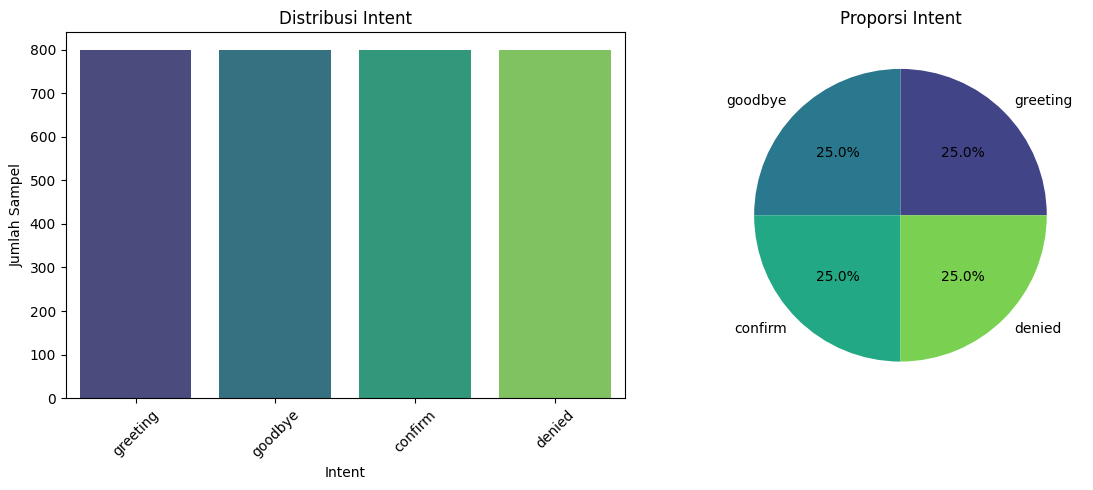


✅ Dataset telah dibagi: 2560 data training dan 640 data validasi
Memuat model IndoBERT...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model berhasil dimuat
Menyiapkan dataset...
Menggunakan class weights: [1. 1. 1. 1.]
Menggunakan device: cuda
Mulai pelatihan model...
Total epoch: 10, batch size: 16, learning rate: 2e-05, weight decay: 0.01

Epoch 1/10 - Training dimulai...


Epoch 1/10 [Training]:   0%|          | 0/160 [00:00<?, ?it/s]

Epoch 1/10 - Validasi dimulai...


Epoch 1/10 [Validation]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/10:
  Train Loss: 0.8623
  Val Loss: 0.3219, Val Accuracy: 89.38%
  Val F1: 0.8946, Val Precision: 0.9001, Val Recall: 0.8938
Menyimpan model terbaik ke /content/drive/MyDrive/indobert_intent_model2

Epoch 2/10 - Training dimulai...


Epoch 2/10 [Training]:   0%|          | 0/160 [00:00<?, ?it/s]

Epoch 2/10 - Validasi dimulai...


Epoch 2/10 [Validation]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2/10:
  Train Loss: 0.2236
  Val Loss: 0.1924, Val Accuracy: 95.47%
  Val F1: 0.9548, Val Precision: 0.9562, Val Recall: 0.9547
Menyimpan model terbaik ke /content/drive/MyDrive/indobert_intent_model2

Epoch 3/10 - Training dimulai...


Epoch 3/10 [Training]:   0%|          | 0/160 [00:00<?, ?it/s]

Epoch 3/10 - Validasi dimulai...


Epoch 3/10 [Validation]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3/10:
  Train Loss: 0.0975
  Val Loss: 0.1975, Val Accuracy: 95.94%
  Val F1: 0.9595, Val Precision: 0.9603, Val Recall: 0.9594
Validation loss tidak membaik. Early stopping counter: 1/3

Epoch 4/10 - Training dimulai...


Epoch 4/10 [Training]:   0%|          | 0/160 [00:00<?, ?it/s]

Epoch 4/10 - Validasi dimulai...


Epoch 4/10 [Validation]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4/10:
  Train Loss: 0.0332
  Val Loss: 0.2205, Val Accuracy: 95.62%
  Val F1: 0.9562, Val Precision: 0.9565, Val Recall: 0.9563
Validation loss tidak membaik. Early stopping counter: 2/3

Epoch 5/10 - Training dimulai...


Epoch 5/10 [Training]:   0%|          | 0/160 [00:00<?, ?it/s]

Epoch 5/10 - Validasi dimulai...


Epoch 5/10 [Validation]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5/10:
  Train Loss: 0.0201
  Val Loss: 0.2603, Val Accuracy: 95.78%
  Val F1: 0.9579, Val Precision: 0.9586, Val Recall: 0.9578
Validation loss tidak membaik. Early stopping counter: 3/3
Early stopping triggered setelah 5 epochs
Pelatihan selesai! Model terbaik disimpan di /content/drive/MyDrive/indobert_intent_model2
Enhanced training history saved to /content/drive/MyDrive/indobert_intent_model2/enhanced_training_history.json
Kalibrasi threshold untuk OOD detection...


Kalibrasi OOD detection:   0%|          | 0/40 [00:00<?, ?it/s]

Energy threshold: -6.1984
MSP threshold: 0.9991
OOD thresholds disimpan di /content/drive/MyDrive/indobert_intent_model2/ood_thresholds.json


Evaluasi Model:   0%|          | 0/40 [00:00<?, ?it/s]


Model Evaluation Report:
Overall Accuracy: 0.9578
Macro F1-score: 0.9579
Weighted F1-score: 0.9579
Enhanced training history saved to /content/drive/MyDrive/indobert_intent_model2/enhanced_training_history.json
Pelatihan selesai! Model terbaik disimpan di /content/drive/MyDrive/indobert_intent_model2

✅ Model telah berhasil dilatih dan disimpan di /content/drive/MyDrive/indobert_intent_model2
Jumlah intent: 4
Intent yang didukung: confirm, denied, goodbye, greeting
OOD detection thresholds: Energy=-6.1984, MSP=0.9991
Visualisasi training telah disimpan di /content/drive/MyDrive/indobert_intent_model2
- Interactive plots dapat dibuka pada file HTML di folder tersebut
- Static plots tersedia dalam format PNG
OOD thresholds loaded: Energy=-6.1984, MSP=0.9991
Menggunakan metode deteksi OOD: combined

Demo Prediksi Intent dengan Enhanced OOD Detection:

Mode Interaktif - Masukkan teks untuk prediksi intent
Ketik 'exit' untuk keluar
----------------------------

Masukkan teks: p
⚠️ Intent t

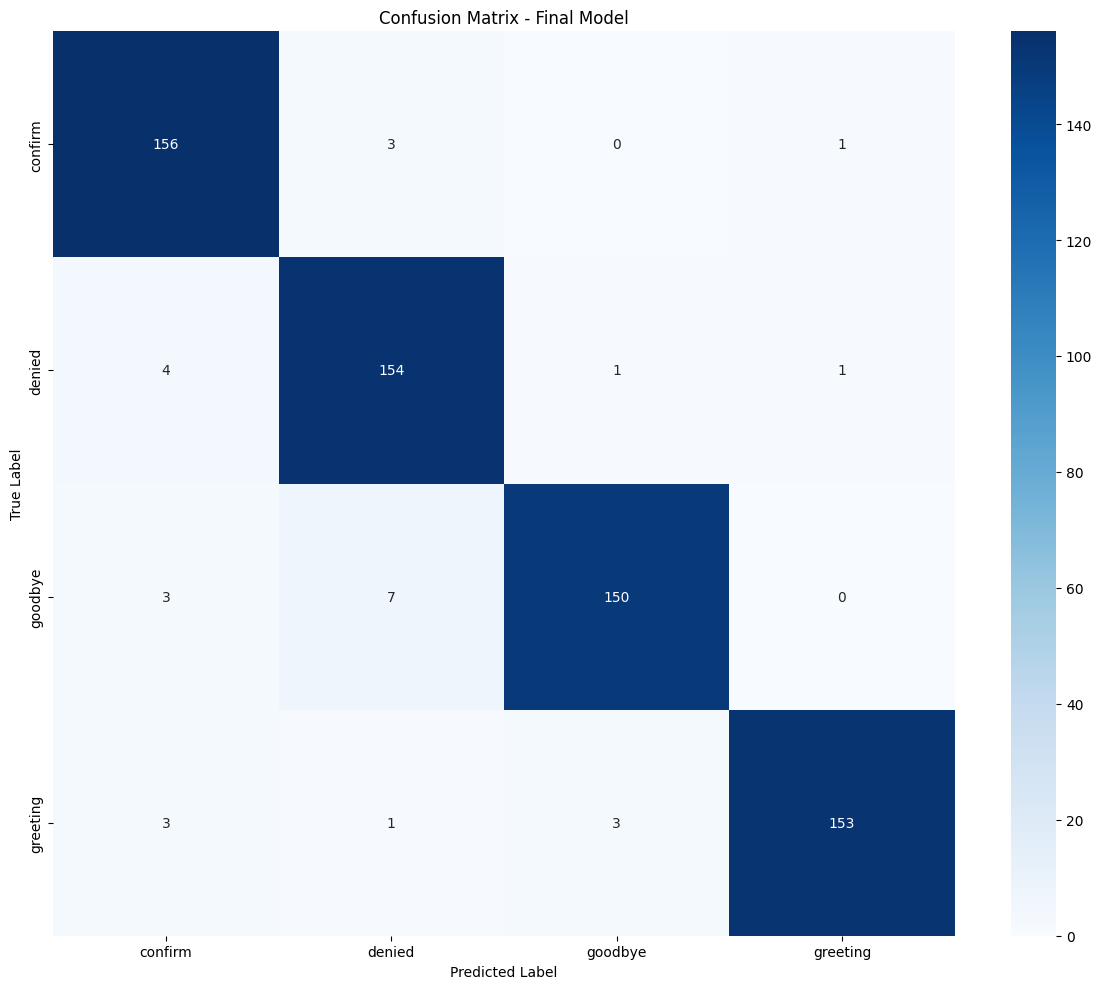

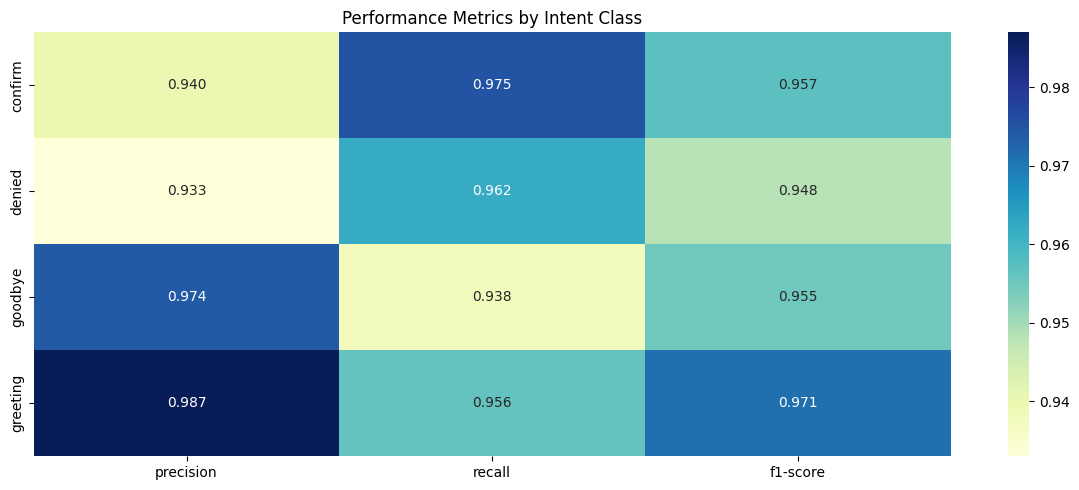

In [57]:
# Cell 13: Jalankan pipeline (uncomment untuk menjalankan)

model, tokenizer, intent_classes, label_encoder = run_full_pipeline_enhanced(
    percentile=85,  # Adjust OOD sensitivity (higher = more strict)
    ood_method='combined',  # Use 'energy', 'msp', or 'combined'
    split_dataset="yes"
)


# Cell 14: Jalankan demo prediksi (uncomment untuk menjalankan)


In [15]:
# @title Teks judul default
test_sentences = [
    # GREETING
    "Halo, selamat pagi!",
    "Apa kabar?",
    "Hai, bot!",
    "Permisi, boleh bertanya?",
    "Yo, ada orang di sana?",

    # GOODBYE
    "Terima kasih, sampai jumpa.",
    "Ok, saya pergi dulu.",
    "Sampai nanti!",
    "Dadah, bot.",
    "Aku akan kembali nanti.",

    # CONFIRM
    "Iya, benar.",
    "Betul sekali.",
    "Ya, saya setuju.",
    "Tentu saja.",
    "Itu yang saya maksud.",

    # DENIED
    "Tidak, bukan itu.",
    "Salah.",
    "Bukan, maksud saya yang lain.",
    "Enggak.",
    "Saya tidak yakin dengan itu.",

    # AMBIGUOUS (bisa mengecoh)
    "Saya rasa tidak perlu, tapi ya juga boleh.",
    "Mungkin... tapi entahlah.",
    "Terserah kamu aja deh.",
    "Boleh iya, boleh juga tidak.",
    "Ya tapi tidak juga sih...",
    "p",
    "test",
    "y",
    "g",
    "N"
]


In [ ]:
# If you want to load an existing model and run predictions
run_prediction_demo_enhanced(
    model_path=MODEL_SAVE_PATH,  # Your MODEL_SAVE_PATH
    method='combined',  # Which OOD detection method to use
    test_texts=test_sentences
)

✅ File dikonversi ke CSV: /content/train.csv
🔄 Augmenting class 'greeting'...
  ✓ Added 700 augmentations for 'greeting'
🔄 Augmenting class 'goodbye'...
  ✓ Added 700 augmentations for 'goodbye'
🔄 Augmenting class 'confirm'...
  ✓ Added 700 augmentations for 'confirm'
🔄 Augmenting class 'denied'...
  ✓ Added 700 augmentations for 'denied'

✅ Augmentasi selesai dan dataset seimbang disimpan di: /content/train.csv

📊 Distribusi Sebelum Augmentasi:


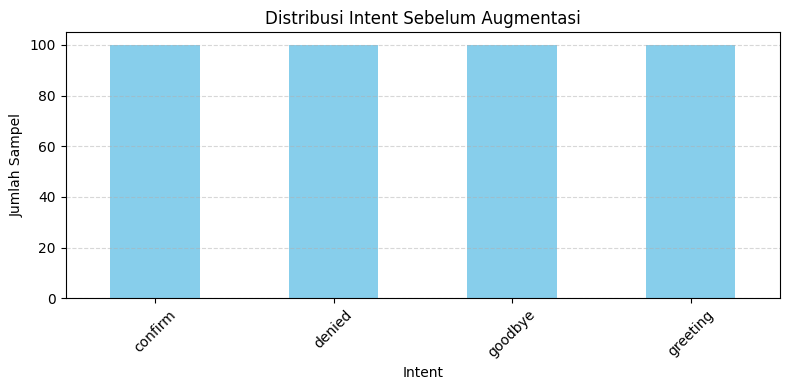


📊 Distribusi Setelah Augmentasi:


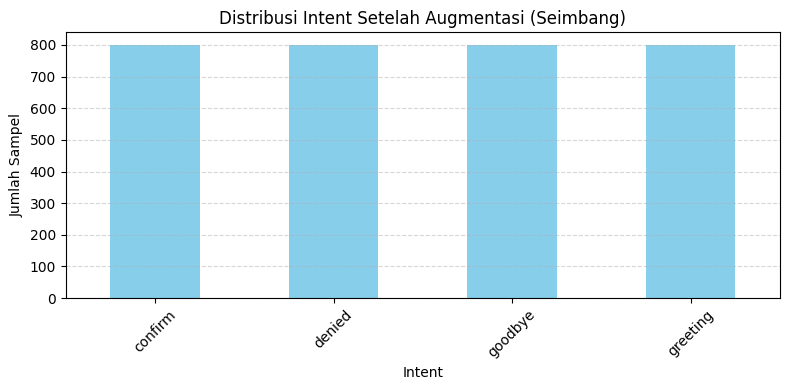

In [54]:
import pandas as pd
import random
import nltk
import matplotlib.pyplot as plt
from deep_translator import GoogleTranslator
from collections import defaultdict
import re

# =========[ IMPROVED SYNONYM DICTIONARY ]=========
# Custom Indonesian synonym dictionary for common words
id_synonyms = {
    # Greeting related words
    "saya": ["aku", "gue", "gua", "hamba", "beta"],
    "kamu": ["anda", "engkau", "kalian", "elu", "dikau"],
    "halo": ["hai", "hey", "hi", "selamat jumpa", "salam", "assalamualaikum"],
    "selamat": ["bahagia", "sukses", "sejahtera"],
    "senang": ["bahagia", "gembira", "ceria", "suka", "girang"],
    "bertemu": ["berjumpa", "ketemu", "bersua", "menjumpai"],
    "rindu": ["kangen", "merindukan", "nostalgia", "damba"],

    # Goodbye related words
    "sampai": ["hingga", "sampai dengan", "sehingga"],
    "jumpa": ["ketemu", "bersua", "bertemu", "berjumpa"],
    "pamit": ["izin", "permisi", "undur diri", "mohon diri"],
    "tinggal": ["berdiam", "bermukim", "menetap"],
    "pergi": ["berangkat", "meninggalkan", "menuju", "bepergian"],
    "pulang": ["kembali", "balik", "mudik", "kembali ke rumah"],

    # Confirm related words
    "ya": ["iya", "benar", "betul", "sungguh", "memang"],
    "setuju": ["sepakat", "akur", "mufakat", "sependapat", "sepaham"],
    "benar": ["betul", "tepat", "akurat", "sahih", "valid"],
    "sudah": ["telah", "usai", "selesai", "rampung", "beres"],
    "bisa": ["mampu", "dapat", "sanggup", "berdaya", "berkemampuan"],
    "pasti": ["tentu", "yakin", "meyakinkan", "positif", "terang"],
    "siap": ["bersedia", "bersiap", "sedia", "bersiaga", "tersedia"],
    "jadi": ["menjadi", "terlaksana", "terjadi", "berlangsung"],
    "lanjut": ["terus", "melanjutkan", "meneruskan", "berlanjut"],
    "mantap": ["hebat", "bagus", "keren", "mengagumkan", "luar biasa"],
    "bagus": ["baik", "indah", "elok", "cantik", "menarik"],
    "tentu": ["pasti", "yakin", "meyakinkan", "terang", "jelas"],

    # Denied related words
    "tidak": ["bukan", "tiada", "tak", "belum", "tanpa"],
    "jangan": ["larang", "cegah", "hindari", "batalkan"],
    "belum": ["masih", "sedang", "tengah", "dalam proses"],
    "batal": ["urung", "gagal", "berhenti", "dibatalkan", "tak jadi"],
    "maaf": ["ampun", "pemaafan", "pengampunan", "mohon maaf"],
    "menolak": ["menampik", "mengelak", "menghindar", "melarang"],
    "mustahil": ["tidak mungkin", "tidak bisa", "sulit", "sukar"],
    "salah": ["keliru", "alpa", "sesat", "khilaf", "menyimpang"],
    "gagal": ["batal", "tidak berhasil", "kalah", "tumbang"],
    "susah": ["sulit", "rumit", "kompleks", "tidak mudah", "berat"],

    # Common words
    "tolong": ["bantu", "sokong", "dukung", "membantu"],
    "besok": ["esok", "hari berikutnya", "keesokan hari"],
    "cukup": ["memadai", "layak", "pantas", "patut", "lumayan"],
    "untuk": ["bagi", "demi", "guna", "buat", "kepada"],
    "ini": ["hal ini", "hal tersebut", "sekarang", "saat ini"],
    "kita": ["kami", "kamu dan saya", "kelompok kita", "tim kita"],
    "fix": ["tetap", "pasti", "permanen", "tidak berubah"],
    "nigga": ["nigger", "hitam", "negro"]

}

# =========[ FILE PATHS ]=========
PilihData = "train"  # @param ["train","val"]
if PilihData == "train":
    file_path = "/content/rusdi-prototype-1/val.xlsx"
    csv_path = "/content/train.csv"
    output_path_balanced = "/content/train.csv"
elif PilihData == "val":
    file_path = "/content/val.xlsx"
    csv_path = "/content/val.csv"
    output_path_balanced = "/content/val.csv"

# =========[ READ & CONVERT XLSX ]=========
if file_path.endswith(".xlsx"):
    df = pd.read_excel(file_path)
    df.to_csv(csv_path, index=False)
    print(f"✅ File dikonversi ke CSV: {csv_path}")
else:
    df = pd.read_csv(file_path)

# =========[ AUGMENTATION METHODS ]=========

def get_better_synonym(word):
    """Get synonym from custom dictionary or return the original word"""
    word_lower = word.lower()
    if word_lower in id_synonyms:
        synonyms = id_synonyms[word_lower]
        return random.choice(synonyms)
    return word

def replace_with_synonym(sentence):
    """Replace words with synonyms while preserving capitalization"""
    words = sentence.split()
    new_words = []

    for word in words:
        synonym = get_better_synonym(word)
        # Preserve capitalization
        if word and word[0].isupper() and synonym:
            synonym = synonym[0].upper() + synonym[1:]
        new_words.append(synonym)

    return " ".join(new_words)

def back_translate(sentence):
    """Translate to English and back to Indonesian"""
    try:
        # First to English
        translated = GoogleTranslator(source='id', target='en').translate(sentence)
        # Then back to Indonesian
        back_translated = GoogleTranslator(source='en', target='id').translate(translated)

        # Only return if result is different but not completely unrelated
        if back_translated != sentence and len(back_translated.split()) >= len(sentence.split()) * 0.5:
            return back_translated
        return sentence
    except Exception:
        return sentence

def add_typo(sentence):
    """Add a single typo by replacing a character"""
    chars = list(sentence)
    if len(chars) > 3:
        idx = random.randint(0, len(chars) - 1)
        if chars[idx].isalpha():  # Only replace letters
            chars[idx] = random.choice("abcdefghijklmnopqrstuvwxyz")
    return "".join(chars)

def random_deletion(sentence, p=0.2):
    """Delete words with probability p"""
    words = sentence.split()
    if len(words) <= 3:  # Don't delete from very short sentences
        return sentence

    new_words = []
    for word in words:
        if random.uniform(0, 1) > p:
            new_words.append(word)

    # Make sure we don't delete everything
    if not new_words:
        return sentence

    return " ".join(new_words)

def random_swap(sentence, n=1):
    """Swap n pairs of words"""
    words = sentence.split()
    if len(words) < 2:
        return sentence

    for _ in range(min(n, len(words)//2)):  # Ensure we don't try too many swaps
        idx1, idx2 = random.sample(range(len(words)), 2)
        words[idx1], words[idx2] = words[idx2], words[idx1]

    return " ".join(words)

def phonetic_augmentation(sentence):
    """Apply phonetic substitutions common in Indonesian chat"""
    phonetic_dict = {
        # Greeting related
        "saya": ["sy", "saia", "ane", "ana", "w", "gw", "q", "aq"],
        "kamu": ["km", "kamyu", "u", "lo", "lu", "l", "ngana", "sampeyan", "antum", "ente"],
        "halo": ["hlo", "hallo", "helo", "haloo", "hellow", "hy", "hyy", "p", "ping"],
        "selamat": ["slmt", "slamat", "met", "slam"],
        "pagi": ["pgi", "morning", "pg", "subuh"],
        "siang": ["siang", "afternoon", "siank", "siyang"],
        "malam": ["mlm", "malem", "mlem", "night", "evening", "mlem", "mlm"],
        "apa": ["ap", "ape", "apah", "pa"],
        "kabar": ["kbr", "kabare", "kbar", "kabbar"],
        "gimana": ["gmn", "bgmn", "gmana", "gimane", "gmn"],

        # Goodbye related
        "sampai": ["smp", "sampe", "smpe", "smpei", "sampeyan"],
        "jumpa": ["jpa", "jmpa", "ktmu", "jumpe"],
        "dadah": ["byebye", "bye", "bay", "byee", "bbye", "bye2", "dadah"],
        "pamit": ["pmt", "pamitt", "off", "out", "cabut", "cbut"],
        "tinggal": ["tgl", "tnggal", "tinggel", "tggal", "tinggelin"],
        "duluan": ["dlu", "duluan", "dluan", "dluan ya", "ahead"],
        "pergi": ["pgi", "pegi", "prgi", "out", "keluar"],
        "pulang": ["plg", "plng", "balik", "blk", "mudik"],

        # Confirm related
        "ya": ["y", "yah", "iye", "yoi", "yups", "yes", "yess", "yesss", "okey", "okeh", "oks"],
        "setuju": ["stju", "acc", "accept", "approved", "approve", "deal", "oke", "ok", "sip"],
        "benar": ["bnr", "bner", "bener", "bnr", "yoi", "correct"],
        "sudah": ["sdh", "dah", "udh", "done", "wes", "uwes", "udah", "sdah"],
        "bisa": ["bs", "bsa", "biza", "bsa", "biza", "ok"],
        "pasti": ["pst", "psti", "pastii", "sure", "certain"],
        "siap": ["sp", "ready", "sip", "sp", "roger", "on", "online"],
        "jadi": ["jd", "jdi", "jdnya", "jdiin", "proceed"],
        "lanjut": ["lnjt", "lanjt", "next", "go"],
        "mantap": ["mntap", "mantab", "mntb", "top", "mantul", "josss", "kerennn"],
        "bagus": ["bgs", "bgus", "nice", "naiss", "keren", "top"],

        # Denied related
        "tidak": ["tdk", "gak", "ga", "g", "nggak", "ngga", "nope", "no", "kagak", "kaga", "kgk"],
        "jangan": ["jgn", "jngn", "don't", "dont", "jgn", "ga usah", "tdk usah", "gausa", "gausah"],
        "belum": ["blm", "blom", "belom", "not yet", "durung", "durong", "belm"],
        "batal": ["btl", "cancel", "cansel", "urungkan", "batalin", "gajadi"],
        "maaf": ["sorry", "sori", "maf", "maap", "maaaaf", "mrff", "sry", "srry"],
        "menolak": ["tlk", "reject", "decline", "dtolak", "nolak", "gak mau", "gamau"],
        "mustahil": ["impossible", "ga mungkin", "g mungkin", "tdk mungkin", "gak bs"],
        "salah": ["slh", "wrong", "error", "eror", "salh", "fail"],
        "gagal": ["ggl", "fail", "failed", "error", "gagak", "failll"],

        # Common words
        "terima": ["trma", "thanks", "thx", "trims", "tq", "tyvm", "makasih", "mksih"],
        "kasih": ["ksh", "ksih", "thx", "makasih", "mksih", "thanks"],
        "tolong": ["tlng", "help", "tlg", "tulung", "bantu", "bantuin"],
        "please": ["plz", "plis", "pliss", "plisss", "pliissss", "tolong"],
        "besok": ["bsk", "bsok", "besok", "tmrw", "esok", "besuk"],
        "waktu": ["wkt", "waktu", "time", "tm", "jam"],
        "cukup": ["ckp", "enough", "cukuppp", "cukups", "ckup"],
        "melihat": ["lihat", "liat", "look", "see", "watching", "ngeliat"],
        "alasan": ["alsan", "reason", "why", "alesan", "alsn"],
        "untuk": ["utk", "buat", "bwt", "4", "tuk", "2", "to"],
        "melakukan": ["lakukan", "do", "lakuin", "melakuin", "ngerjain"],
        "ini": ["ni", "this", "these", "iki", "nih", "ne"],
        "kita": ["kta", "we", "us", "w", "kt"],
        "hari": ["hr", "day", "hri", "days", "dayy", "harii"],
        "bro": ["broh", "brow", "brother", "mas", "bang", "bor", "omm"],
        "sis": ["sist", "sister", "mbak", "mba", "nte", "ceu", "teh"]
    }

    words = sentence.split()
    new_words = []

    for word in words:
        word_lower = word.lower()
        if word_lower in phonetic_dict:
            new_word = random.choice(phonetic_dict[word_lower])
            # Preserve capitalization
            if word and word[0].isupper():
                new_word = new_word[0].upper() + new_word[1:]
            new_words.append(new_word)
        else:
            new_words.append(word)

    return " ".join(new_words)

def add_common_phrase(sentence):
    """Add a common Indonesian chat phrase"""
    common_phrases = ["sih", "ya", "anjay", "dong", "cuy", "bro", "lah", "plis", "eh",
                      "nih", "gitu", "kan", "yah", "deh", "banget"]
    return sentence + " " + random.choice(common_phrases)

def validate_augmentation(original, augmented):
    """Validate if augmentation is reasonable"""
    # Check if augmentation is too different
    if len(augmented.split()) < len(original.split()) * 0.5:
        return False

    # Check if augmentation is just the original
    if augmented == original:
        return False

    # Check if augmentation contains too many non-Indonesian characters
    non_indo_pattern = re.compile(r'[^a-zA-Z0-9\s.,?!\'"-:;()[\]{}]')
    if len(non_indo_pattern.findall(augmented)) > 2:
        return False

    return True

# Combined augmentations
def augment_data(text):
    """Generate multiple augmentations for a text"""
    methods = [
        replace_with_synonym,
        back_translate,
        add_typo,
        random_deletion,
        random_swap,
        phonetic_augmentation,
        add_common_phrase
    ]

    augmented = set()
    for method in methods:
        try:
            result = method(text)
            if validate_augmentation(text, result):
                augmented.add(result)
        except Exception as e:
            print(f"Error applying {method.__name__}: {str(e)}")
            continue

    return list(augmented)

# =========[ BALANCED AUGMENTATION ]=========
target_aug_per_class = 700  # Can be changed (e.g., 100 augmented per class)
intent_buckets = defaultdict(list)

# Group original data by intent
for _, row in df.iterrows():
    intent_buckets[row['intent']].append(row['text'])

df_augmented_balanced = []

# Augment per class until target reached
for intent, texts in intent_buckets.items():
    current_aug_count = 0
    index = 0
    existing_aug_set = set()
    print(f"🔄 Augmenting class '{intent}'...")

    # Limit iterations to prevent infinite loops
    max_iterations = 1000
    iterations = 0

    while current_aug_count < target_aug_per_class and iterations < max_iterations:
        original_text = texts[index % len(texts)]
        augmented_variants = augment_data(original_text)

        for aug in augmented_variants:
            if aug not in existing_aug_set:
                df_augmented_balanced.append([aug, intent])
                existing_aug_set.add(aug)
                current_aug_count += 1
                if current_aug_count >= target_aug_per_class:
                    break

        index += 1
        iterations += 1

    print(f"  ✓ Added {current_aug_count} augmentations for '{intent}'")

# Combine original + augmented
df_original = df[['text', 'intent']]
df_augmented_balanced = pd.DataFrame(df_augmented_balanced, columns=["text", "intent"])
df_final = pd.concat([df_original, df_augmented_balanced], ignore_index=True)

# Save to CSV
df_final.to_csv(output_path_balanced, index=False)
print(f"\n✅ Augmentasi selesai dan dataset seimbang disimpan di: {output_path_balanced}")

# =========[ PLOTTING DISTRIBUTIONS ]=========
def plot_distribution(data, title):
    plt.figure(figsize=(8, 4))
    data['intent'].value_counts().sort_index().plot(kind='bar', color='skyblue')
    plt.title(title)
    plt.xlabel("Intent")
    plt.ylabel("Jumlah Sampel")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Show before/after plots
print("\n📊 Distribusi Sebelum Augmentasi:")
plot_distribution(df_original, "Distribusi Intent Sebelum Augmentasi")

print("\n📊 Distribusi Setelah Augmentasi:")
plot_distribution(df_final, "Distribusi Intent Setelah Augmentasi (Seimbang)")

In [3]:
import shutil

source_path = '/content/rusdi-prototype-1/val.xlsx'
destination_path = '/content/val.xlsx'

shutil.copy(source_path, destination_path)
print(f"File copied from '{source_path}' to '{destination_path}'")

File copied from '/content/rusdi-prototype-1/val.xlsx' to '/content/val.xlsx'


In [ ]:
# prompt: xlsx to csv convert

import pandas as pd

# Replace 'input.xlsx' with the actual path to your Excel fle
excel_file = '/content/rusdi-prototype-1/val.xlsx'

# Replace 'output.csv' with the desired path and name for your CSV file
csv_file = 'val.csv'

try:
  # Read the Excel file into a Pandas DataFrame
  df = pd.read_excel(excel_file)

  # Convert the DataFrame to a CSV file
  df.to_csv(csv_file, index=False)

  print(f"Successfully converted '{excel_file}' to '{csv_file}'")

except FileNotFoundError:
  print(f"Error: File '{excel_file}' not found.")
except Exception as e:
  print(f"An error occurred: {e}")


Successfully converted '/content/rusdi-prototype-1/val.xlsx' to 'val.csv'


In [ ]:
# @title Teks judul default
# prompt: the model already trained and saved to drive, but can i test the model without running thee training.

# Path ke folder model di Google Drive
model_path = "/content/drive/MyDrive/indobert_intent_model"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Load model
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Load intent classes
with open(f"{model_path}/intent_classes.pkl", "rb") as f:
    intent_classes = pickle.load(f)

# Load label encoder (jika diperlukan)
with open(f"{model_path}/label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)


def predict_intent(text, model, tokenizer, intent_classes, device=None):
    """Memprediksi intent dari teks input"""

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)
    model.eval()

    # Tokenisasi input
    inputs = tokenizer(
        text,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=128
    )

    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Prediksi
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)
        prediction = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0][prediction].item()

    predicted_intent = intent_classes[prediction]

    # Dapatkan top 3 intent dengan confidence tertinggi
    top_k = 3
    if len(intent_classes) < top_k:
        top_k = len(intent_classes)

    topk_values, topk_indices = torch.topk(probabilities, top_k, dim=1)
    topk_intents = [(intent_classes[idx.item()], val.item()) for idx, val in zip(topk_indices[0], topk_values[0])]

    return predicted_intent, confidence, topk_intents


# Contoh penggunaan
    while True:
        user_input = input("\nMasukkan teks untuk prediksi intent (ketik 'exit' untuk keluar): ")
        if user_input.lower() == 'exit':
            break

        intent, confidence, topk = predict_intent(user_input, model, tokenizer, intent_classes)
        print(f"Intent terdeteksi: {intent} (confidence: {confidence:.4f})")
        print("Top 3 intent:")
        for i, (intent_name, score) in enumerate(topk):
            print(f"  {i+1}. {intent_name}: {score:.4f}")

